# Exercise 4

**_DISCLAIMER:_** The notation used in this exercise follows the one of the Probabilistic Robotics book (refer to Chapter 5.4 in case you have doubts).

## 4.1 Inverse motion model

The odometry model uses the _relative motion information_. The odometry readings are $u_t = [{\overline{x}}_{t-1} , {\overline{x}}_{t}]$, where $\overline{x}_{t-1}$ and  $\overline{x}_t$ are poses in a robot-internal coordinate frame (different from the map).

The function `inverse_motion_model` takes as input an odometry reading $u_t$ that consist in:

- the initial pose of the robot in the odometry coordinate frame $\overline{x}_{t-1} = [\overline{x},\overline{y},\overline{\theta}]$
- the estimated pose of the robot in the odometry coordinate frame $\overline{x}_t = [\overline{x}',\overline{y}',\overline{\theta}']$

The output is the relative motion $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$.

Implement the function `inverse_motion_model` and verify that it is correct for some test input. **[2.0]**

In [1]:
from ex4 import *
import math
import numpy as np
import matplotlib.pyplot as plt

inverse_motion_model([[0, 0, 0], [1, 0, 0]])  # Pure translation
inverse_motion_model([[0, 0, 0], [1, 1, 0]])  # translation + rotation



(0.7853981633974483, 1.4142135623730951, -0.7853981633974483)

## 4.2 Odometry-based motion model

The function `motion_model_odometry` computes the posterior $p(x_t | u_t, x_{t-1})$ from odometry readings.

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the hypothesized (or query) final pose $x_{t} = [x', y', \theta']$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is the probability $p(x_t | u_t, x_{t-1})$

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [1.0, 1.0, 0.01, 0.01]$.

The robot excecutes one motion command and the odometry readings are:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$

Implement the `motion_model_odometry` function and verify that it is correct for some test input. **[1.0]**

---

Consider a 150x150 grid map the world with a resolution of 0.01, centered in the original position of the robot.

Plot the posterior $p(x_t | u_t, x_{t-1})$ for all possible $[x, y]$ values from the grid. **[2.0]**

**Note that** the query input is a position, not a pose. Therefore, to plot the posterior belief over the gridmap, you can assume the term $\hat{\delta}_\mathrm{rot2}$ to be zero and, for each position, integrate over all possible orientations. This can be implemented by considering $p_3 = 1.0$ in the equations. 

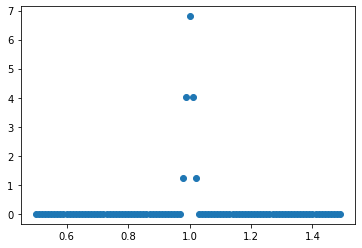

In [2]:
u = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]  # u = (x,x')T
x_0 = [0.0, 0.0, 0.0]
alpha = [1.0, 1.0, 0.01, 0.01]
p = []
x = []
for i in range(100):
    if i <= 50:
        query = [1.0-(0.01*i), 0.0, 0.0]
    else:
        query = [1+(0.01)*(i-50), 0.0, 0.0]
    x.append(query[0])
    probs = motion_model_odometry(x_0, query, u, alpha)
    p.append(probs)

plt.scatter(x, p)
plt.show()


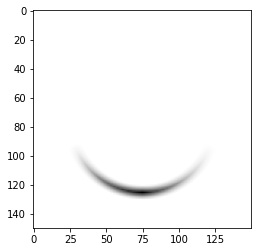

In [3]:
gridmap = np.zeros((150, 150))
u_t = [[0.0, 0.0, 0.0], [0.5, 0.0, math.pi/2]]
x_init = [2.0, 3.0, 0.0]
alpha = [1.0, 1.0, 0.01, 0.01]

for i in range(gridmap.shape[0]):
    for j in range(gridmap.shape[1]):
        # Using triangular distibution
        gridmap[i][j] = motion_model_odometry(x_init, map2world(gridmap,i, j, x_init,), u_t, alpha)
        
        # Using normal distibution
        #gridmap[i][j] = motion_model_odometry(x_init, map2world(gridmap,i, j, x_init,), u_t, alpha)

plot_map(gridmap)


## 4.3 Sample odometry motion model

The `motion_model_odometry` requires high computation complexity and does not scale well to large real-world environments. 

One effective approach to approximate $p(x_t | u_t, x_{t-1})$ is to use **sampling**.

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. **[2.0]**

In [4]:
x_0 = np.array([0.0, 0.0, 0.0])
alpha = np.array([0.1, 0.1, 0.01, 0.01])
u = np.array([[0.0, 0.0, 0.0], [2.0, 0.0, 0.0]])

x =[]
y =[]
for i in range(1000):
    pose = sample_motion_model_odometry(x_0,u,alpha)
    x.append(pose[0])
    y.append(pose[1])
x = np.array(x)
y = np.array(y)


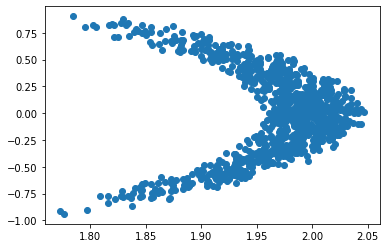

In [5]:
plt.scatter(x,y)

## 4.4 Evaluate sample odometry motion model

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [0.1, 0.1, 0.01, 0.01]$.

The robot obtains the following odometry readings:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$
3. $\overline{x}_2 = [0.5 , 0.5 , 0.0   ]$
4. $\overline{x}_3 = [1.0 , 0.5 , 0.0   ]$
5. $\overline{x}_4 = [1.0 , 1.5 , \pi/2 ]$
6. $\overline{x}_5 = [1.0 , 2.5 , \pi/2 ]$

Evaluate the `sample_motion_model_odometry` by considering 1000 samples and plot the resulting positions for each sample in one unique plot. **[3.0]**

In [6]:
commands = [[0.0, 0.0, 0.0], [0.5, 0.0, math.pi/2],
            [0.5, 0.5, 0.0], [1.0, 0.5, 0.0],
            [1.0, 1.5, math.pi/2], [1.0, 2.5, math.pi/2]]
alpha = np.array([0.1, 0.1, 0.01, 0.01])

trajectory = np.array([0.0, 0.0, 0.0])

x_0 = np.array([2.0, 3.0, 0.0])

samples = np.array([x_0]*1000)

for i in range(len(commands)-1):
    init = x_0 + np.array(commands[i])
    trajectory = np.vstack((trajectory, init))

    u = [commands[i], commands[i+1]]
    itr = (i)*1000

    for j in range(1000):
        pose = sample_motion_model_odometry(samples[itr+j], u, alpha)
        samples = np.vstack((samples, np.array(pose)))
# append the last commmand to trajectory for visualization
trajectory = np.vstack((trajectory, x_0 + np.array(commands[-1])))
# print(trajectory)


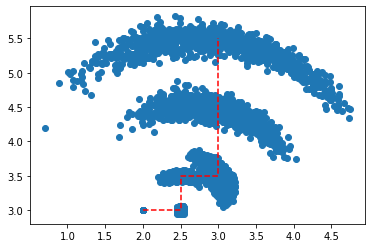

In [7]:
#red line : actual motion without any errors
#scatter plot : the sample of the position probilities
plt.scatter(samples[:,0],samples[:,1])
plt.plot(trajectory[1:,0],trajectory[1:,1],'--r')